In [37]:
import pandas as pd
import json
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/poldrack/MID_simulations/main/AHRB/participants.tsv', sep='\t')
# sub 05 had corrupted event files
df = df.query('participant_id != "sub-05"')
print(df.shape)
df.head()

(107, 5)


,participant_id,age,sex,race,days_ses1toses2
0,sub-01,20.5,0,1,367.0
1,sub-02,18.8,0,1,411.0
2,sub-03,19.7,1,1,NaN
3,sub-04,18.5,1,1,NaN
5,sub-06,19.8,0,3,NaN


In [12]:
with open('AHRB/participants.json') as f:
    participants = json.load(f)
participants

{'participant_id': {'LongName': 'BIDS Subject ID',
  'Description': 'This is the BIDS subject ID for the AHRB MRI data'},
 'age': {'LongName': 'Age',
  'Description': 'Age at Scan Session 01 (AHRB Study: Phase II Wave I)'},
 'sex': {'LongName': 'Sex', 'Levels': {'0': 'Female', '1': 'Male'}},
 'race': {'LongName': 'Race/Enthnicity',
  'Description': 'Race/Ethnicity reported by participants per requirements for NIH participant enrollment.',
  'Levels': {'1': 'White Non-Hispanic',
   '2': 'Black Non-Hispanic',
   '3': 'Hispanic/Latinx',
   '4': 'American Indian/Alaska Native/Asian/Native Hawaiian or Pacific Islander/More than one race'}},
 'days_ses1toses2': {'LongName': 'Days Between Ses1 & Ses2',
  'Description': 'These are the number of days between scans from Phase 2 Wave 1 to Phase 2 Wave2'}}

In [8]:
df.describe()

,age,sex,race,days_ses1toses2
count,107.000000,107.000000,107.000000,64.000000
mean,19.310280,0.420561,1.485981,417.437500
std,1.311627,0.495972,0.872694,78.354683
min,17.000000,0.000000,1.000000,352.000000
25%,18.100000,0.000000,1.000000,369.750000
50%,19.200000,0.000000,1.000000,388.500000
75%,20.500000,1.000000,2.000000,432.000000
max,21.400000,1.000000,4.000000,692.000000


### confirm event number details for paper

In [16]:
df = pd.read_csv('AHRB/sub-01/ses-1/func/sub-01_ses-1_task-mid_run-01_events.tsv', sep='\t')
df.head()

,TRIAL_TYPE,CUE_ONSET,CUE_DURATION,FIXATION_ONSET,FIXATION_DURATION,PROBE_ONSET,PROBE_DURATION,FEEDBACK_ONSET,FEEDBACK_DURATION,TRIAL_RESULT,RESULT_REASON,PROBE_HIT,PROBE_MRT
0,NoMoneyStake,0.058,2,2.008,2.0,4.007,0.319,4.407,1.631,No money at stake!,You pressed too slow!,0,0
1,NoMoneyStake,6.024,2,8.007,1.5,9.506,0.319,9.906,1.631,No money at stake!,You pressed too slow!,0,0
2,LargeLoss,11.556,2,13.506,2.5,16.005,0.319,16.405,1.631,You keep $5!,Correct Response!,1,306
3,NoMoneyStake,18.022,2,20.005,1.5,21.504,0.319,21.904,1.631,No money at stake!,Correct Response!,1,318
4,LargeGain,23.554,2,25.504,1.5,27.004,0.319,27.403,1.631,You did not earn $5!,You pressed too slow!,0,0


In [17]:
df.TRIAL_TYPE.value_counts()

TRIAL_TYPE
NoMoneyStake    10
LargeLoss       10
LargeGain       10
SmallLoss       10
SmallGain       10
Name: count, dtype: int64

### Get behavioral details

In [19]:
def get_subdata(sub, run, verbose=False):
    sub = str(sub).zfill(2)
    eventfile = f'https://raw.githubusercontent.com/poldrack/MID_simulations/main/AHRB/sub-{sub}/ses-1/func/sub-{sub}_ses-1_task-mid_run-0{run}_events.tsv'
    df = pd.read_csv(eventfile, sep='\t')
    if verbose:
        print(f'Loading {eventfile}')
        print(df.shape)
    assert df.shape[1] > 2, f'bad parsing'
    return df


In [22]:
# load events files for all subjects, skipping the bad one
events_df = None
for sub in np.arange(1, 109):
    for run in [1, 2]:
        try:
            events = get_subdata(sub, run)
        except:
            print(f'Error loading sub {sub}')
            continue
        events['sub'] = sub
        events['run'] = run
        if events_df is None:
            events_df = events
        else:
            events_df = pd.concat([events_df, events])


Error loading sub 5
Error loading sub 5


In [23]:
events_df.head()

,TRIAL_TYPE,CUE_ONSET,CUE_DURATION,FIXATION_ONSET,FIXATION_DURATION,PROBE_ONSET,PROBE_DURATION,FEEDBACK_ONSET,FEEDBACK_DURATION,TRIAL_RESULT,RESULT_REASON,PROBE_HIT,PROBE_MRT,sub,run
0,NoMoneyStake,0.058,2,2.008,2.0,4.007,0.319,4.407,1.631,No money at stake!,You pressed too slow!,0,0,1,1
1,NoMoneyStake,6.024,2,8.007,1.5,9.506,0.319,9.906,1.631,No money at stake!,You pressed too slow!,0,0,1,1
2,LargeLoss,11.556,2,13.506,2.5,16.005,0.319,16.405,1.631,You keep $5!,Correct Response!,1,306,1,1
3,NoMoneyStake,18.022,2,20.005,1.5,21.504,0.319,21.904,1.631,No money at stake!,Correct Response!,1,318,1,1
4,LargeGain,23.554,2,25.504,1.5,27.004,0.319,27.403,1.631,You did not earn $5!,You pressed too slow!,0,0,1,1


In [45]:
events_df.replace({'TRIAL_TYPE': {'NoMoneyStake': 'Neutral'}}, inplace=True)
probe_hit_mean = events_df.groupby(['sub', 'TRIAL_TYPE'])['PROBE_HIT'].mean()
probe_hit_mean = probe_hit_mean.reset_index()

probe_rt_mean = events_df.query('PROBE_HIT == 1').groupby(['sub', 'TRIAL_TYPE'])['PROBE_MRT'].mean()
probe_rt_mean = probe_rt_mean.reset_index()

(150.0, 400.0)

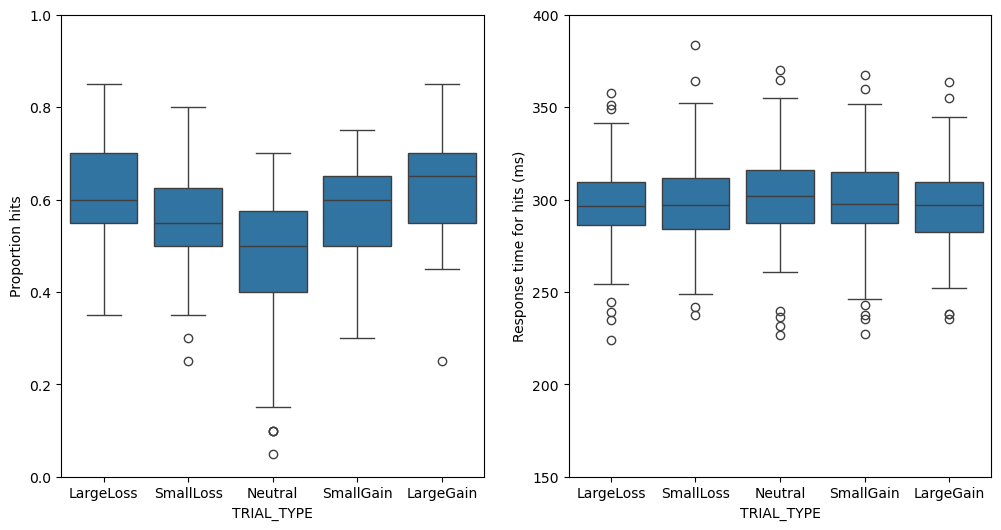

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
order = ['LargeLoss', 'SmallLoss', 'Neutral', 'SmallGain', 'LargeGain']
sns.boxplot(data=probe_hit_mean, x='TRIAL_TYPE', y='PROBE_HIT', order=order, ax=ax[0])
ax[0].set_ylabel('Proportion hits')
ax[0].set_ylim(0, 1)

sns.boxplot(data=probe_rt_mean, x='TRIAL_TYPE', y='PROBE_MRT', order=order, ax=ax[1])
ax[1].set_ylabel('Response time for hits (ms)')
ax[1].set_ylim(150, 400)